In [76]:
import torch 
import torch.nn as nn
from torchvision.transforms import v2, ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchsummary import summary
from torchmetrics import Accuracy

from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import json
from math import ceil

In [77]:
basic_mb_params = [
    # Expand ratio, out channels, num layers, stride, kernel_size
    # k, c, t, s, k
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

alpha, beta = 1.2, 1.1

scale_values = {
    # (Phi, resolution, dropout)

    "b0": (0, 224, 0.2),
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

In [78]:
"""
Fundamental convolution block:
    1 ==> Convolution layer
    2 ==> Batch normalization
    3 ==> Silu activation function
"""

class ConvBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups=1):
        super(ConvBlock, self).__init__()

        self.block = nn.Sequential(
            
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding,
                      groups=groups), # Specified to control how convolution is applied to input
                                      # If group = 1, kernel is applied to one channel only
                                      # if group = input channel, kernel is applied to one channel only

            nn.BatchNorm2d(out_channels),
            nn.SiLU()
        )
    
    def forward(self, x):
        return self.block(x)

In [79]:
"""
Squeeze and Excitation Block:
    Goal: To enhance feature representation by selectively amplifying important channels
    Mechanism: Take number of input channels as input and applying adaptive pooling to condense spatial dimensions
"""

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

In [80]:
"""
MobileNet-style Convolution Block (MBConv):
    Depthwise separable convolutions
    Squeeze-and-excitation block (SE)
"""

class MBConv(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, ratio, reduction=2):
        super(MBConv, self).__init__()

        hidden_dim = in_channels * ratio
        self.expand = in_channels != hidden_dim

        # Squeeze and excitation block
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = ConvBlock(in_channels=in_channels,
                                         out_channels=hidden_dim,
                                         kernel_size=3,
                                         stride=1,
                                         padding=1)
        
        self.conv = nn.Sequential(
            ConvBlock(in_channels=hidden_dim,
                      out_channels=hidden_dim,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding,
                      groups=hidden_dim),

            SqueezeExcitation(in_channels=hidden_dim,
                              reduced_dim=reduced_dim),

            nn.Conv2d(in_channels=hidden_dim,
                      out_channels=out_channels,
                      kernel_size=1),

            nn.BatchNorm2d(out_channels)
        )

    def forward(self, inputs):
        if self.expand:
            x = self.expand_conv(inputs)
        else:
            x = inputs
            
        return self.conv(x)

In [81]:
"""
EfficientNet Class
"""

class EfficientNet(nn.Module):
    def __init__(self, model_name, output, mb_params, dropout_newVal, linear_hiddenUnits_list=None):
        super(EfficientNet, self).__init__()
        
        phi, resolution, dropout = scale_values[model_name]

        if dropout_newVal != None:
            dropout = dropout_newVal

        if mb_params == None:
            mb_params = basic_mb_params

        self.mb_params = mb_params
        self.depth_factor, self.width_factor = alpha**phi, beta**phi
        self.last_channels = ceil(1280 * self.width_factor)
        self.avgpool= nn.AdaptiveAvgPool2d(1)
        self.feature_extractor()
        self.flatten = nn.Flatten()
        
        if linear_hiddenUnits_list == None:
            self.classifier = nn.Sequential(
                nn.Dropout(p=dropout),
                nn.Linear(in_features=self.last_channels,
                        out_features=output),
                nn.Softmax()
            )

        else:
            feed_forward_network_layers = [nn.Dropout(p=dropout)]
            feed_forward_network_layers.append(nn.Linear(self.last_channels, linear_hiddenUnits_list[0]))

            for i in range(0, len(linear_hiddenUnits_list)-1):
                feed_forward_network_layers.append(nn.Linear(linear_hiddenUnits_list[i], linear_hiddenUnits_list[i+1]))
                feed_forward_network_layers.append(nn.ReLU())

            feed_forward_network_layers.append(nn.Linear(linear_hiddenUnits_list[-1], output))
            feed_forward_network_layers.append(nn.ReLU())

            self.classifier = nn.Sequential(*feed_forward_network_layers)

    def feature_extractor(self):
        channels = int(32 * self.width_factor)
        features = [ConvBlock(3, channels, 3, stride=2, padding=1)] # Stem convolution layer
        in_channels = channels

        for k, c_o, repeat, s, n in self.mb_params:
            # For numeric stability, we multiply and divide by 4
            out_channels = 4 * ceil(int(c_o * self.width_factor) / 4)
            num_layers = ceil(repeat * self.depth_factor)

            for layer in range(num_layers):
                if layer == 0:
                  stride = s
                else:
                  stride = 1
                
                features.append(
                        MBConv(in_channels=in_channels,
                               out_channels=out_channels,
                               ratio=k,
                               stride=stride,
                               kernel_size=n,
                               padding=(n//2))
                )
                in_channels = out_channels

        features.append(
            ConvBlock(in_channels=in_channels,
                      out_channels=self.last_channels,
                      kernel_size=1,
                      stride=1,
                      padding=0)
        )
        self.extractor = nn.Sequential(*features)

    def forward(self, x):
        x = self.avgpool(self.extractor(x))
        
        return self.classifier(self.flatten(x))

In [82]:
## Dictionary for encoding labels

labelToNum_dict = {
    "angry" : 0,
    "disgust" : 1,
    "fear" : 2,
    "happy" : 3,
    "neutral" : 4,
    "sad" : 5,
    "surprise" : 6,
}

numTolabel_dict = {
    0 : "angry",
    1 : "disgust",
    2 : "fear",
    3 : "happy",
    4 : "neutral",
    5 : "sad",
    6: "surprise"
}

In [83]:
def loadDataset(res, batch_size, datasetType):
    base_dir = os.getcwd()
    folder_dir = os.path.join(base_dir, "processed_data", datasetType)
    
    transformation = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True), # Convert image to float ranging from 0 - 1
        v2.Resize((res, res)),
    ])

    dataset = ImageFolder(folder_dir, transform=transformation)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return loader


Train features batch shape: torch.Size([32, 3, 224, 224])
Train labels batch size: torch.Size([32])


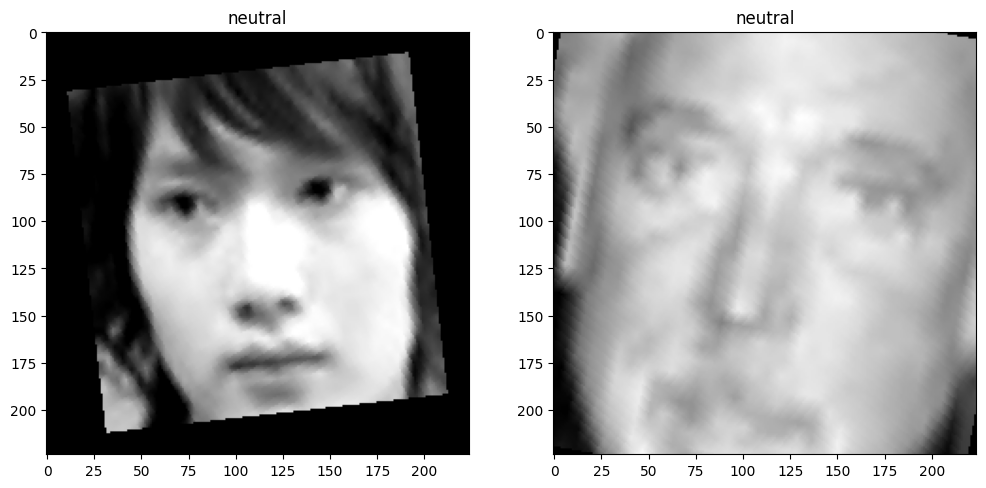

In [84]:
## New loading and testing train and validation datasets

train_loader = loadDataset(224, 32, "train")
val_loader = loadDataset(224, 32, "validation")

x_train, y_train = next(iter(train_loader))
x_val, y_val = next(iter(val_loader))

print(f"Train features batch shape: {x_train.size()}")
print(f"Train labels batch size: {y_train.size()}")

imgTrain = x_train[0].squeeze()
labelTrain = y_train[0]

imgVal = x_val[0].squeeze()
labelVal = y_val[0]

fig = plt.figure(figsize=(12,7))

plt.subplot(1,2,1)
plt.imshow(imgTrain.permute(1,2,0))
plt.title(numTolabel_dict[labelTrain.item()])

plt.subplot(1,2,2)
plt.imshow(imgVal.permute(1,2,0))
plt.title(numTolabel_dict[labelVal.item()])
plt.show()


In [85]:
def setHyperparameters(model_type, num_class, batchSize, learningRate, device, mb_params, newDropoutRate, optimChoice, linear_hiddenUnits_list=None):
    
    phi, resolution, dropout = scale_values[model_type]

    train_loader = loadDataset(resolution, batchSize, "train")
    test_loader = loadDataset(resolution, batchSize, "test")
    val_loader = loadDataset(resolution, batchSize, "validation")

    model = EfficientNet(model_name=model_type,
                         output=num_class,
                         mb_params=mb_params,
                         dropout_newVal=newDropoutRate,
                         linear_hiddenUnits_list=linear_hiddenUnits_list)
    
    model.to(device)

    match (optimChoice):
        case "Adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
        
        case "AdamW":
            optimizer = torch.optim.AdamW(model.parameters(), lr=learningRate)
        
        case "Adadelta":
            optimizer = torch.optim.Adadelta(model.parameters(), lr=learningRate)
        
        case "SGD":
            optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
        
        case _:
            print("ERROR. Optimizer choice inputted is not included in selection.\n PLEASE RESET MODEL OPTIMIZER's CHOICE.\n")

    return model, train_loader, test_loader, val_loader, optimizer

In [86]:
## Testing for whether CUDA is available for training

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("CUDA not available. Using CPU.")

Using GPU: NVIDIA GeForce RTX 4060 Ti


In [87]:
## Function for training model

def train_model(model, train_loader, device, lossFn, accFn, optimizer):
    
    torch.manual_seed(42) # 42 is the answer to everything!
    
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(tqdm(train_loader, desc="Training Model on Num Batches")):
        model.train()

        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X) # Still in logits from (probabilities)

        # 2. Calculate loss (per batch)
        loss = lossFn(y_pred, y)
        train_loss += loss
        train_acc += accFn(y_pred.argmax(dim=1), y)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
    
    # Divide total train loss and accuracy by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    train_acc *= 100

    return model, optimizer, train_loss, train_acc

In [88]:
## Function for testing model

def test_model(model, test_loader, device, lossFn, accFn):
    
    torch.manual_seed(42)

    test_loss, test_acc = 0, 0
    model.eval()

    with torch.inference_mode():
        for batch, (X, y) in enumerate(tqdm(test_loader, desc="Testing Model")):
            
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss (accumulatively)
            test_loss += lossFn(test_pred, y)

            # 3. Calculate accuracy (preds need to be same as y)
            test_acc += accFn(test_pred.argmax(dim=1), y)
        
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_loader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_loader)

        # Times 100 to make it into a percentage
        test_acc *= 100
    
    return model, test_loss, test_acc

In [89]:
## Function for entire training and testing loop with data saving

def model_train_test(model, epochs, train_loader, test_loader, device, lossFn, accFn, optimizer):
    history = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    for epoch in range(0, epochs):

        print(f"\nEpoch {epoch+1} / {epochs}: ---------------------------")

        ### Training
        model, optimizer, train_loss, train_acc = train_model(model, train_loader, device, lossFn, accFn, optimizer)

        ### Testing
        model, test_loss, test_acc = test_model(model, test_loader, device, lossFn, accFn)
        
        print(f"\nTrain loss: {train_loss:.4f}, Train acc: {train_acc:.2f}%")
        print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%\n")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)
    
    print("\n-------Model has finished training-------\n")
    
    return model, history
    

In [90]:
## Function to save model and model weights

def save_model_and_modelWeights(model, model_name):
    base_path = os.getcwd()
    folder_path = os.path.join(base_path, "model_files")

    if not os.path.isdir(folder_path):
        os.mkdir(folder_path)

    model_path = os.path.join(folder_path, model_name)

    if not os.path.isdir(model_path):
        os.mkdir(model_path)

    modelStateDictName = model_name + "_weights.pth"
    modelEntireName = model_name + ".pth"

    modelStateDict_path = os.path.join(model_path, modelStateDictName)
    modelEntire_path = os.path.join(model_path, modelEntireName)

    # Save model's weight only
    if os.path.isfile(modelStateDict_path):
        print(f"\n{model_name} state dictionary file existed previously. New {model_name}'s state is not saved.")
    else:
        torch.save(model.state_dict(), modelStateDict_path)
        print(f"\n{model_name}'s state file has been successfully saved.")

    # Save entire model including layers and weights
    if os.path.isfile(modelEntire_path):
        print(f"\n{model_name} file existed previously. New {model_name} is not saved.")
    else:
        torch.save(model, modelEntire_path)
        print(f"\n{model_name} has been successfully saved.")

In [91]:
def save_modelSettings(model_settings, model_name):
    base_path = os.getcwd()
    folder_path = os.path.join(base_path, "model_files")

    if not os.path.isdir(folder_path):
        os.mkdir(folder_path)

    model_path = os.path.join(folder_path, model_name)

    if not os.path.isdir(model_path):
        os.mkdir(model_path)
    
    json_path = os.path.join(model_path, model_name+"_settings.json")

    if os.path.isfile(json_path):
        print(f"\n{model_name}'s settings file existed previously. New {model_name}'s settings file is not saved.\n")

    else:
        with open(json_path, 'w') as file:
            json.dump(model_settings, file)
        
        print(f"\n{model_name}'s setting has been saved.\n")

In [92]:
## Function to show and save model history

def show_and_save_trainTest_history(history, model_name):
    base_path = os.getcwd()
    folder_path = os.path.join(base_path, "model_files")

    if not os.path.isdir(folder_path):
        os.mkdir(folder_path)

    model_path = os.path.join(folder_path, model_name)

    if not os.path.isdir(model_path):
        os.mkdir(model_path)
    
    json_path = os.path.join(model_path, model_name+"_history.json")

    # Convert json in tensor to normal data

    new_history = {}

    for key, dataL in history.items():
        new_history[key] = []
        for i in range(0, len(dataL)):
            new_history[key].append(dataL[i].item())

    if os.path.isfile(json_path):
        print(f"\n{model_name}'s history file existed previously. New {model_name}'s history file is not saved.\n")

    else:
        with open(json_path, 'w') as file:
            json.dump(new_history, file)
        
        print(f"\n{model_name}'s training history has been saved.\n")

    # Checking model's training history

    for val_type in history:
        print(val_type)
        dataList = history[val_type]
        for i in range(0, len(history[val_type])):
            print(f"{i+1}. {dataList[i]:.4f}")
        print("")

In [93]:
## Class for model hyperparameters and training settings

class ModelSet:
    def __init__(self, model_name, model_type, epochs, batchSize, learningRate, mb_params, newDropoutRate, optimChoice, linear_hiddenUnits_list):
        self.model_name = model_name
        self.model_type = model_type
        self.num_class = 7
        self.epochs = epochs
        self.batchSize = batchSize
        self.learningRate = learningRate
        self.mb_params = mb_params
        self.newDropoutRate = newDropoutRate
        self.history = None
        self.optimChoice = optimChoice
        self.linear_hiddenUnits_list = linear_hiddenUnits_list
    
    def model_setup(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self.model, self.train_loader, self.test_loader, self.val_loader, self.optimizer = setHyperparameters(model_type=self.model_type,
                                                                                                              num_class=self.num_class,
                                                                                                              batchSize=self.batchSize,
                                                                                                              learningRate=self.learningRate,
                                                                                                              device=self.device,
                                                                                                              mb_params=self.mb_params,
                                                                                                              newDropoutRate=self.newDropoutRate,
                                                                                                              optimChoice=self.optimChoice,
                                                                                                              linear_hiddenUnits_list=self.linear_hiddenUnits_list)

        self.lossFn = nn.CrossEntropyLoss()

        self.accFn = Accuracy('multiclass', num_classes=self.num_class).to(self.device)
    
    ## Function to save model settings as json file

    def generate_modelSettings_dict(self):

        phi, res, ori_dp_rate = scale_values[self.model_type]

        if self.newDropoutRate == None:
            self.newDropoutRate = ori_dp_rate

        modelSettings = {"model_name": self.model_name,
                         "model_type": self.model_type,
                         "num_class": 7,
                         "epochs": self.epochs,
                         "batch_size": self.batchSize,
                         "learning_rate": self.learningRate,
                         "MBConv parameters": self.mb_params,
                         "dropout_rate": self.newDropoutRate,
                         "optimizer": self.optimChoice,
                         "linear_layers_hidden_units": self.linear_hiddenUnits_list,
                         "loss_function": "Cross Entropy Loss"}
        
        return modelSettings

In [94]:
## Do not change this, only for reference!!
basic_mb_params = [
    # Expand ratio, out channels, num layers, stride, kernel_size
    # k, c, t, s, k
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

## Change any settings you want on this one
mb_params = [
    # Expand ratio, out channels, num layers, stride, kernel_size
    # k, c, t, s, k
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

## Do not change anything with it, only for reference!!
scale_values = {
    # (Phi, resolution, dropout)

    "b0": (0, 224, 0.2),
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

In [95]:
## Function for brute force grid-search hyperparameter tuning

"""
hyperparameters_lists --> Must be a dictionary with each hyperparameter as a key and the value must be a list of int/float/list with equal length

Currently tunable hyperparameters --> epoch : Not to underfit / overfit
                                  --> learningRate : Ensure model converges towards the global minimum
                                  --> dropOutRate : Ensure model does not overfit and learn the actual features of the dataset given
                                  --> linear_hiddenUnits_list : Ensure the feed-forward neural network can be beneficial in guessing the correct label

Currently untunable hyperparameters --> model_type : EfficientNet-b0 architecture is sufficient for this project
                                    --> batchSize : 32 is the sweet spot without risking underfit / overfit
                                    --> mb_params : We would not change to model architecture due to it being optimal from the research paper 
                                                    (Would be resource-intensive and time-consuming to tune it anyways)
                                    --> optimChoiceL : Adam is the most balanced and stable optimizer which does not suffer major decreases in performance when training model

"""
def hyperparameterGridSearch(hyperparameters_lists, num_sets):
    
    hyperparameter_history = {"train_loss": [],
                              "train_acc" : [],
                              "val_loss": [],
                              "val_acc": []}
    
    for i in range(0, 7):

        currentSet = hyperparameters_lists[i]

        model_name = "model_grid" + str(i+1)

        model_grid = ModelSet(model_name=model_name, # Change names if you want to save different versions of models
                              model_type="b0", # from b0 --> b7
                              epochs=currentSet[0], 
                              batchSize=32, # Typically in the power of 2
                              learningRate=currentSet[1], # Different choices for different optimizers
                              mb_params=mb_params, # Can refer to previous block / If None, use basic_mb_params
                              newDropoutRate=currentSet[2], # Can refer to previous block / If None, use basic dropout rate
                              optimChoice="Adam", # Available choice: Adam, AdamW, Adadelta, SGD
                              linear_hiddenUnits_list=currentSet[3]) # Each value refers to an additional hidden Linear layer with x neuron before the final classification
        
        model_grid.model_setup()
        
        model_grid_Settings = model_grid.generate_modelSettings_dict()

        model_grid.model, model_grid.history = model_train_test(model=model_grid.model,
                                                                epochs=model_grid.epochs,
                                                                train_loader=model_grid.train_loader,
                                                                test_loader=model_grid.val_loader,
                                                                device=model_grid.device,
                                                                lossFn=model_grid.lossFn,
                                                                accFn=model_grid.accFn,
                                                                optimizer=model_grid.optimizer)

        show_and_save_trainTest_history(model_grid.history, model_grid.model_name)
        save_modelSettings(model_grid_Settings, model_grid.model_name)

        
        hyperparameter_history["train_loss"].append((model_grid.history["train_loss"])[-1])
        hyperparameter_history["train_acc"].append((model_grid.history["train_acc"])[-1])

        hyperparameter_history["val_loss"].append((model_grid.history["test_loss"])[-1])
        hyperparameter_history["val_acc"].append((model_grid.history["test_acc"])[-1])
    
    return hyperparameter_history

In [96]:
## Hyperparameter Tuning

# Original value: 15, 0.0012, 0.3, [1024, 256, 64]
# Form: epoch, learningRate, dropoutRate, linear_hiddenUnits_list
# Key: ep, lr, dr, lhu
hyperparameters_list = []

# Set 1
temp1 = [15, 0.0012, 0.3, [1024, 256, 64]]

# Set 2
temp2 = [12, 0.0012, 0.4, [1024, 256, 64]]

# Set 3
temp3 = [13, 0.001, 0.3, [1024, 256, 64]]

# Set 4
temp4 = [15, 0.0012, 0.2, [256, 64]]

# Set 5
temp5 = [16, 0.00125, 0.3, [512, 128, 64]]

# Set 6
temp6 = [14, 0.0012, 0.25, [512, 32]]

# Set 7
temp7 = [15, 0.0011, 0.35, [1024, 256, 64]]

hyperparameters_list.append(temp1)
hyperparameters_list.append(temp2)
hyperparameters_list.append(temp3)
hyperparameters_list.append(temp4)
hyperparameters_list.append(temp5)
hyperparameters_list.append(temp6)
hyperparameters_list.append(temp7)

hyperparameter_history = hyperparameterGridSearch(hyperparameters_list, 7)


Epoch 1 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:08<00:00, 13.10it/s]



Train loss: 1.8852, Train acc: 24.75%
Test loss: 1.9088, Test acc: 19.84%


Epoch 2 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:07<00:00, 14.62it/s]



Train loss: 1.8712, Train acc: 25.08%
Test loss: 1.8794, Test acc: 24.53%


Epoch 3 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:07<00:00, 14.33it/s]



Train loss: 1.8693, Train acc: 24.98%
Test loss: 1.8765, Test acc: 24.53%


Epoch 4 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:08<00:00, 13.56it/s]



Train loss: 1.8641, Train acc: 25.10%
Test loss: 1.8619, Test acc: 24.53%


Epoch 5 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:08<00:00, 13.60it/s]



Train loss: 1.8573, Train acc: 25.30%
Test loss: 1.8662, Test acc: 24.53%


Epoch 6 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:08<00:00, 13.27it/s]



Train loss: 1.8521, Train acc: 25.31%
Test loss: 1.8434, Test acc: 27.87%


Epoch 7 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:08<00:00, 12.93it/s]



Train loss: 1.8130, Train acc: 28.31%
Test loss: 1.7811, Test acc: 29.38%


Epoch 8 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 12.55it/s]



Train loss: 1.7640, Train acc: 30.52%
Test loss: 1.7334, Test acc: 33.67%


Epoch 9 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 12.18it/s]



Train loss: 1.6920, Train acc: 34.50%
Test loss: 1.6594, Test acc: 36.68%


Epoch 10 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 12.00it/s]



Train loss: 1.6300, Train acc: 37.36%
Test loss: 1.5841, Test acc: 39.50%


Epoch 11 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 11.69it/s]



Train loss: 1.5679, Train acc: 39.97%
Test loss: 1.5499, Test acc: 41.50%


Epoch 12 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 11.50it/s]



Train loss: 1.5177, Train acc: 42.01%
Test loss: 1.5245, Test acc: 41.92%


Epoch 13 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:10<00:00, 11.05it/s]



Train loss: 1.4790, Train acc: 43.16%
Test loss: 1.5000, Test acc: 41.75%


Epoch 14 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:10<00:00, 10.65it/s]



Train loss: 1.4482, Train acc: 44.63%
Test loss: 1.5058, Test acc: 41.64%


Epoch 15 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:11<00:00, 10.19it/s]



Train loss: 1.4234, Train acc: 45.31%
Test loss: 1.4786, Test acc: 43.74%


-------Model has finished training-------


model_grid1's training history has been saved.

train_loss
1. 1.8852
2. 1.8712
3. 1.8693
4. 1.8641
5. 1.8573
6. 1.8521
7. 1.8130
8. 1.7640
9. 1.6920
10. 1.6300
11. 1.5679
12. 1.5177
13. 1.4790
14. 1.4482
15. 1.4234

train_acc
1. 24.7508
2. 25.0849
3. 24.9840
4. 25.0954
5. 25.3041
6. 25.3146
7. 28.3074
8. 30.5185
9. 34.4996
10. 37.3650
11. 39.9680
12. 42.0128
13. 43.1612
14. 44.6346
15. 45.3132

test_loss
1. 1.9088
2. 1.8794
3. 1.8765
4. 1.8619
5. 1.8662
6. 1.8434
7. 1.7811
8. 1.7334
9. 1.6594
10. 1.5841
11. 1.5499
12. 1.5245
13. 1.5000
14. 1.5058
15. 1.4786

test_acc
1. 19.8396
2. 24.5299
3. 24.5299
4. 24.5299
5. 24.5299
6. 27.8706
7. 29.3805
8. 33.6670
9. 36.6759
10. 39.4967
11. 41.5044
12. 41.9193
13. 41.7533
14. 41.6427
15. 43.7445


model_grid1's setting has been saved.


Epoch 1 / 12: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:08<00:00, 14.00it/s]



Train loss: 1.9103, Train acc: 24.34%
Test loss: 1.9134, Test acc: 24.53%


Epoch 2 / 12: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:08<00:00, 12.68it/s]



Train loss: 1.8984, Train acc: 25.13%
Test loss: 1.8989, Test acc: 24.53%


Epoch 3 / 12: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 12.49it/s]



Train loss: 1.8966, Train acc: 25.04%
Test loss: 1.9002, Test acc: 24.53%


Epoch 4 / 12: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 12.26it/s]



Train loss: 1.8934, Train acc: 25.03%
Test loss: 1.8983, Test acc: 24.53%


Epoch 5 / 12: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 11.88it/s]



Train loss: 1.9063, Train acc: 21.63%
Test loss: 1.9459, Test acc: 13.55%


Epoch 6 / 12: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 11.62it/s]



Train loss: 1.9425, Train acc: 14.70%
Test loss: 1.9457, Test acc: 13.88%


Epoch 7 / 12: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 11.34it/s]



Train loss: 1.9111, Train acc: 20.96%
Test loss: 1.9049, Test acc: 24.03%


Epoch 8 / 12: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:10<00:00, 11.05it/s]



Train loss: 1.8878, Train acc: 24.77%
Test loss: 1.9011, Test acc: 24.56%


Epoch 9 / 12: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:10<00:00, 10.72it/s]



Train loss: 1.8821, Train acc: 25.06%
Test loss: 1.9006, Test acc: 24.53%


Epoch 10 / 12: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:11<00:00, 10.24it/s]



Train loss: 1.8792, Train acc: 24.94%
Test loss: 1.8831, Test acc: 24.53%


Epoch 11 / 12: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:11<00:00,  9.87it/s]



Train loss: 1.8454, Train acc: 25.52%
Test loss: 1.8608, Test acc: 24.53%


Epoch 12 / 12: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:11<00:00,  9.66it/s]



Train loss: 1.8339, Train acc: 25.79%
Test loss: 1.8596, Test acc: 24.53%


-------Model has finished training-------


model_grid2's training history has been saved.

train_loss
1. 1.9103
2. 1.8984
3. 1.8966
4. 1.8934
5. 1.9063
6. 1.9425
7. 1.9111
8. 1.8878
9. 1.8821
10. 1.8792
11. 1.8454
12. 1.8339

train_acc
1. 24.3437
2. 25.1267
3. 25.0362
4. 25.0292
5. 21.6342
6. 14.7042
7. 20.9626
8. 24.7682
9. 25.0640
10. 24.9422
11. 25.5234
12. 25.7913

test_loss
1. 1.9134
2. 1.8989
3. 1.9002
4. 1.8983
5. 1.9459
6. 1.9457
7. 1.9049
8. 1.9011
9. 1.9006
10. 1.8831
11. 1.8608
12. 1.8596

test_acc
1. 24.5299
2. 24.5299
3. 24.5299
4. 24.5299
5. 13.5454
6. 13.8772
7. 24.0321
8. 24.5575
9. 24.5299
10. 24.5299
11. 24.5299
12. 24.5299


model_grid2's setting has been saved.


Epoch 1 / 13: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:08<00:00, 13.43it/s]



Train loss: 1.9463, Train acc: 14.06%
Test loss: 1.9459, Test acc: 13.55%


Epoch 2 / 13: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:08<00:00, 13.18it/s]



Train loss: 1.9459, Train acc: 13.94%
Test loss: 1.9459, Test acc: 13.55%


Epoch 3 / 13: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 12.34it/s]



Train loss: 1.9459, Train acc: 13.94%
Test loss: 1.9459, Test acc: 13.55%


Epoch 4 / 13: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 12.29it/s]



Train loss: 1.9459, Train acc: 13.94%
Test loss: 1.9459, Test acc: 13.55%


Epoch 5 / 13: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 11.93it/s]



Train loss: 1.9459, Train acc: 13.94%
Test loss: 1.9459, Test acc: 13.55%


Epoch 6 / 13: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 11.43it/s]



Train loss: 1.9459, Train acc: 13.94%
Test loss: 1.9459, Test acc: 13.55%


Epoch 7 / 13: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 11.42it/s]



Train loss: 1.9459, Train acc: 13.94%
Test loss: 1.9459, Test acc: 13.55%


Epoch 8 / 13: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:10<00:00, 11.26it/s]



Train loss: 1.9459, Train acc: 13.94%
Test loss: 1.9459, Test acc: 13.55%


Epoch 9 / 13: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:10<00:00, 10.45it/s]



Train loss: 1.9459, Train acc: 13.94%
Test loss: 1.9459, Test acc: 13.55%


Epoch 10 / 13: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:11<00:00, 10.15it/s]



Train loss: 1.9459, Train acc: 13.94%
Test loss: 1.9459, Test acc: 13.55%


Epoch 11 / 13: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:11<00:00,  9.84it/s]



Train loss: 1.9459, Train acc: 13.94%
Test loss: 1.9459, Test acc: 13.55%


Epoch 12 / 13: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:11<00:00,  9.52it/s]



Train loss: 1.9459, Train acc: 13.94%
Test loss: 1.9459, Test acc: 13.55%


Epoch 13 / 13: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:12<00:00,  9.28it/s]



Train loss: 1.9459, Train acc: 13.94%
Test loss: 1.9459, Test acc: 13.55%


-------Model has finished training-------


model_grid3's training history has been saved.

train_loss
1. 1.9463
2. 1.9459
3. 1.9459
4. 1.9459
5. 1.9459
6. 1.9459
7. 1.9459
8. 1.9459
9. 1.9459
10. 1.9459
11. 1.9459
12. 1.9459
13. 1.9459

train_acc
1. 14.0618
2. 13.9400
3. 13.9400
4. 13.9400
5. 13.9400
6. 13.9400
7. 13.9400
8. 13.9400
9. 13.9400
10. 13.9400
11. 13.9400
12. 13.9400
13. 13.9400

test_loss
1. 1.9459
2. 1.9459
3. 1.9459
4. 1.9459
5. 1.9459
6. 1.9459
7. 1.9459
8. 1.9459
9. 1.9459
10. 1.9459
11. 1.9459
12. 1.9459
13. 1.9459

test_acc
1. 13.5454
2. 13.5454
3. 13.5454
4. 13.5454
5. 13.5454
6. 13.5454
7. 13.5454
8. 13.5454
9. 13.5454
10. 13.5454
11. 13.5454
12. 13.5454
13. 13.5454


model_grid3's setting has been saved.


Epoch 1 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:08<00:00, 12.64it/s]



Train loss: 1.8852, Train acc: 23.80%
Test loss: 1.8819, Test acc: 24.25%


Epoch 2 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:08<00:00, 12.65it/s]



Train loss: 1.8811, Train acc: 24.30%
Test loss: 1.8932, Test acc: 23.20%


Epoch 3 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 11.50it/s]



Train loss: 1.8730, Train acc: 24.77%
Test loss: 1.8778, Test acc: 23.79%


Epoch 4 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:10<00:00, 10.95it/s]



Train loss: 1.8709, Train acc: 23.78%
Test loss: 1.8774, Test acc: 24.36%


Epoch 5 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:10<00:00, 10.72it/s]



Train loss: 1.8786, Train acc: 24.07%
Test loss: 1.8773, Test acc: 23.56%


Epoch 6 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:11<00:00,  9.96it/s]



Train loss: 1.8753, Train acc: 23.79%
Test loss: 1.8904, Test acc: 23.64%


Epoch 7 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:11<00:00,  9.54it/s]



Train loss: 1.8763, Train acc: 23.78%
Test loss: 1.8731, Test acc: 24.53%


Epoch 8 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:11<00:00,  9.67it/s]



Train loss: 1.8706, Train acc: 23.92%
Test loss: 1.8869, Test acc: 23.26%


Epoch 9 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:12<00:00,  9.10it/s]



Train loss: 1.8696, Train acc: 24.77%
Test loss: 1.8800, Test acc: 24.34%


Epoch 10 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:12<00:00,  9.15it/s]



Train loss: 1.8743, Train acc: 24.11%
Test loss: 1.8829, Test acc: 23.79%


Epoch 11 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:12<00:00,  8.82it/s]



Train loss: 1.8850, Train acc: 22.07%
Test loss: 1.9078, Test acc: 21.08%


Epoch 12 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:13<00:00,  8.55it/s]



Train loss: 1.8912, Train acc: 21.51%
Test loss: 1.8881, Test acc: 22.36%


Epoch 13 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:15<00:00,  7.31it/s]



Train loss: 1.8764, Train acc: 23.28%
Test loss: 1.9423, Test acc: 13.87%


Epoch 14 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:14<00:00,  7.82it/s]



Train loss: 1.8755, Train acc: 23.26%
Test loss: 1.8868, Test acc: 22.99%


Epoch 15 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:14<00:00,  7.82it/s]



Train loss: 1.8666, Train acc: 24.27%
Test loss: 1.8847, Test acc: 23.88%


-------Model has finished training-------


model_grid4's training history has been saved.

train_loss
1. 1.8852
2. 1.8811
3. 1.8730
4. 1.8709
5. 1.8786
6. 1.8753
7. 1.8763
8. 1.8706
9. 1.8696
10. 1.8743
11. 1.8850
12. 1.8912
13. 1.8764
14. 1.8755
15. 1.8666

train_acc
1. 23.8043
2. 24.3019
3. 24.7703
4. 23.7813
5. 24.0736
6. 23.7883
7. 23.7834
8. 23.9156
9. 24.7745
10. 24.1084
11. 22.0671
12. 21.5145
13. 23.2767
14. 23.2614
15. 24.2671

test_loss
1. 1.8819
2. 1.8932
3. 1.8778
4. 1.8774
5. 1.8773
6. 1.8904
7. 1.8731
8. 1.8869
9. 1.8800
10. 1.8829
11. 1.9078
12. 1.8881
13. 1.9423
14. 1.8868
15. 1.8847

test_acc
1. 24.2533
2. 23.2024
3. 23.7942
4. 24.3639
5. 23.5619
6. 23.6449
7. 24.5299
8. 23.2577
9. 24.3363
10. 23.7942
11. 21.0841
12. 22.3562
13. 13.8661
14. 22.9923
15. 23.8772


model_grid4's setting has been saved.


Epoch 1 / 16: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 12.30it/s]



Train loss: 1.8849, Train acc: 24.25%
Test loss: 1.8798, Test acc: 24.53%


Epoch 2 / 16: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 12.29it/s]



Train loss: 1.8728, Train acc: 25.11%
Test loss: 1.8744, Test acc: 24.53%


Epoch 3 / 16: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 12.02it/s]



Train loss: 1.8636, Train acc: 25.10%
Test loss: 1.8720, Test acc: 24.53%


Epoch 4 / 16: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:10<00:00, 10.46it/s]



Train loss: 1.8572, Train acc: 25.01%
Test loss: 1.8718, Test acc: 24.53%


Epoch 5 / 16: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:12<00:00,  8.79it/s]



Train loss: 1.8548, Train acc: 24.99%
Test loss: 1.8827, Test acc: 24.50%


Epoch 6 / 16: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:11<00:00,  9.71it/s]



Train loss: 1.8524, Train acc: 25.22%
Test loss: 1.8763, Test acc: 24.64%


Epoch 7 / 16: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:12<00:00,  9.25it/s]



Train loss: 1.8326, Train acc: 26.20%
Test loss: 1.9047, Test acc: 25.58%


Epoch 8 / 16: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:12<00:00,  9.02it/s]



Train loss: 1.7873, Train acc: 29.09%
Test loss: 1.7991, Test acc: 29.44%


Epoch 9 / 16: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:12<00:00,  8.78it/s]



Train loss: 1.7624, Train acc: 30.12%
Test loss: 1.7797, Test acc: 30.32%


Epoch 10 / 16: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:13<00:00,  8.45it/s]



Train loss: 1.7283, Train acc: 30.15%
Test loss: 1.6934, Test acc: 30.85%


Epoch 11 / 16: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:14<00:00,  8.02it/s]



Train loss: 1.6562, Train acc: 33.01%
Test loss: 1.7138, Test acc: 32.73%


Epoch 12 / 16: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:14<00:00,  7.94it/s]



Train loss: 1.6275, Train acc: 35.09%
Test loss: 1.6472, Test acc: 35.11%


Epoch 13 / 16: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:14<00:00,  7.83it/s]



Train loss: 1.5717, Train acc: 37.29%
Test loss: 1.6157, Test acc: 38.37%


Epoch 14 / 16: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:14<00:00,  7.64it/s]



Train loss: 1.4938, Train acc: 40.84%
Test loss: 1.5627, Test acc: 39.00%


Epoch 15 / 16: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:15<00:00,  7.51it/s]



Train loss: 1.4331, Train acc: 43.43%
Test loss: 1.4693, Test acc: 43.58%


Epoch 16 / 16: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:15<00:00,  7.27it/s]



Train loss: 1.3923, Train acc: 45.05%
Test loss: 1.4430, Test acc: 44.80%


-------Model has finished training-------


model_grid5's training history has been saved.

train_loss
1. 1.8849
2. 1.8728
3. 1.8636
4. 1.8572
5. 1.8548
6. 1.8524
7. 1.8326
8. 1.7873
9. 1.7624
10. 1.7283
11. 1.6562
12. 1.6275
13. 1.5717
14. 1.4938
15. 1.4331
16. 1.3923

train_acc
1. 24.2532
2. 25.1058
3. 25.0954
4. 25.0118
5. 24.9875
6. 25.2206
7. 26.2020
8. 29.0869
9. 30.1204
10. 30.1482
11. 33.0088
12. 35.0863
13. 37.2926
14. 40.8366
15. 43.4312
16. 45.0508

test_loss
1. 1.8798
2. 1.8744
3. 1.8720
4. 1.8718
5. 1.8827
6. 1.8763
7. 1.9047
8. 1.7991
9. 1.7797
10. 1.6934
11. 1.7138
12. 1.6472
13. 1.6157
14. 1.5627
15. 1.4693
16. 1.4430

test_acc
1. 24.5299
2. 24.5299
3. 24.5299
4. 24.5299
5. 24.5022
6. 24.6405
7. 25.5752
8. 29.4358
9. 30.3208
10. 30.8462
11. 32.7268
12. 35.1051
13. 38.3684
14. 39.0044
15. 43.5785
16. 44.7954


model_grid5's setting has been saved.


Epoch 1 / 14: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 11.98it/s]



Train loss: 1.8796, Train acc: 24.94%
Test loss: 1.8832, Test acc: 24.50%


Epoch 2 / 14: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 11.75it/s]



Train loss: 1.8737, Train acc: 25.08%
Test loss: 1.9179, Test acc: 19.39%


Epoch 3 / 14: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 11.55it/s]



Train loss: 1.8738, Train acc: 25.11%
Test loss: 1.8762, Test acc: 24.53%


Epoch 4 / 14: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:10<00:00, 11.16it/s]



Train loss: 1.8721, Train acc: 25.12%
Test loss: 1.8768, Test acc: 24.53%


Epoch 5 / 14: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:11<00:00,  9.73it/s]



Train loss: 1.8657, Train acc: 25.14%
Test loss: 1.8647, Test acc: 24.59%


Epoch 6 / 14: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:12<00:00,  8.97it/s]



Train loss: 1.8012, Train acc: 25.14%
Test loss: 1.7949, Test acc: 24.53%


Epoch 7 / 14: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:13<00:00,  8.67it/s]



Train loss: 1.7639, Train acc: 27.03%
Test loss: 1.7669, Test acc: 29.72%


Epoch 8 / 14: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:13<00:00,  8.68it/s]



Train loss: 1.6996, Train acc: 30.15%
Test loss: 1.6745, Test acc: 31.65%


Epoch 9 / 14: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:13<00:00,  8.21it/s]



Train loss: 1.6506, Train acc: 32.48%
Test loss: 1.6177, Test acc: 34.83%


Epoch 10 / 14: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:14<00:00,  7.79it/s]



Train loss: 1.5532, Train acc: 37.27%
Test loss: 1.5138, Test acc: 39.20%


Epoch 11 / 14: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:14<00:00,  7.62it/s]



Train loss: 1.4881, Train acc: 40.05%
Test loss: 1.4752, Test acc: 40.98%


Epoch 12 / 14: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:15<00:00,  7.11it/s]



Train loss: 1.4431, Train acc: 41.86%
Test loss: 1.4695, Test acc: 41.59%


Epoch 13 / 14: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:15<00:00,  7.19it/s]



Train loss: 1.4001, Train acc: 43.31%
Test loss: 1.4805, Test acc: 41.01%


Epoch 14 / 14: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:16<00:00,  6.88it/s]



Train loss: 1.3640, Train acc: 44.28%
Test loss: 1.4266, Test acc: 42.64%


-------Model has finished training-------


model_grid6's training history has been saved.

train_loss
1. 1.8796
2. 1.8737
3. 1.8738
4. 1.8721
5. 1.8657
6. 1.8012
7. 1.7639
8. 1.6996
9. 1.6506
10. 1.5532
11. 1.4881
12. 1.4431
13. 1.4001
14. 1.3640

train_acc
1. 24.9422
2. 25.0814
3. 25.1128
4. 25.1197
5. 25.1406
6. 25.1406
7. 27.0302
8. 30.1517
9. 32.4833
10. 37.2661
11. 40.0452
12. 41.8583
13. 43.3122
14. 44.2803

test_loss
1. 1.8832
2. 1.9179
3. 1.8762
4. 1.8768
5. 1.8647
6. 1.7949
7. 1.7669
8. 1.6745
9. 1.6177
10. 1.5138
11. 1.4752
12. 1.4695
13. 1.4805
14. 1.4266

test_acc
1. 24.5022
2. 19.3861
3. 24.5299
4. 24.5299
5. 24.5852
6. 24.5299
7. 29.7235
8. 31.6482
9. 34.8285
10. 39.1980
11. 40.9790
12. 41.5874
13. 41.0066
14. 42.6383


model_grid6's setting has been saved.


Epoch 1 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 11.53it/s]



Train loss: 1.9019, Train acc: 24.92%
Test loss: 1.9043, Test acc: 24.53%


Epoch 2 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:10<00:00, 10.93it/s]



Train loss: 1.8959, Train acc: 25.13%
Test loss: 1.9058, Test acc: 24.53%


Epoch 3 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 11.51it/s]



Train loss: 1.8863, Train acc: 25.05%
Test loss: 1.8860, Test acc: 24.53%


Epoch 4 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 11.54it/s]



Train loss: 1.8950, Train acc: 22.27%
Test loss: 1.9087, Test acc: 20.89%


Epoch 5 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:10<00:00, 10.65it/s]



Train loss: 1.9127, Train acc: 20.07%
Test loss: 1.9295, Test acc: 16.73%


Epoch 6 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:12<00:00,  9.18it/s]



Train loss: 1.9417, Train acc: 14.65%
Test loss: 1.9459, Test acc: 13.55%


Epoch 7 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:13<00:00,  8.64it/s]



Train loss: 1.9459, Train acc: 13.94%
Test loss: 1.9459, Test acc: 13.55%


Epoch 8 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:13<00:00,  8.12it/s]



Train loss: 1.9459, Train acc: 13.94%
Test loss: 1.9459, Test acc: 13.55%


Epoch 9 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:15<00:00,  7.40it/s]



Train loss: 1.9459, Train acc: 13.94%
Test loss: 1.9459, Test acc: 13.55%


Epoch 10 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:15<00:00,  7.32it/s]



Train loss: 1.9459, Train acc: 13.94%
Test loss: 1.9459, Test acc: 13.55%


Epoch 11 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:14<00:00,  7.64it/s]



Train loss: 1.9459, Train acc: 13.94%
Test loss: 1.9459, Test acc: 13.55%


Epoch 12 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:15<00:00,  7.24it/s]



Train loss: 1.9459, Train acc: 13.94%
Test loss: 1.9459, Test acc: 13.55%


Epoch 13 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:15<00:00,  7.47it/s]



Train loss: 1.9459, Train acc: 13.94%
Test loss: 1.9459, Test acc: 13.55%


Epoch 14 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:15<00:00,  7.09it/s]



Train loss: 1.9459, Train acc: 13.94%
Test loss: 1.9459, Test acc: 13.55%


Epoch 15 / 15: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:16<00:00,  6.66it/s]



Train loss: 1.9459, Train acc: 13.94%
Test loss: 1.9459, Test acc: 13.55%


-------Model has finished training-------


model_grid7's training history has been saved.

train_loss
1. 1.9019
2. 1.8959
3. 1.8863
4. 1.8950
5. 1.9127
6. 1.9417
7. 1.9459
8. 1.9459
9. 1.9459
10. 1.9459
11. 1.9459
12. 1.9459
13. 1.9459
14. 1.9459
15. 1.9459

train_acc
1. 24.9214
2. 25.1267
3. 25.0501
4. 22.2710
5. 20.0717
6. 14.6534
7. 13.9400
8. 13.9400
9. 13.9400
10. 13.9400
11. 13.9400
12. 13.9400
13. 13.9400
14. 13.9400
15. 13.9400

test_loss
1. 1.9043
2. 1.9058
3. 1.8860
4. 1.9087
5. 1.9295
6. 1.9459
7. 1.9459
8. 1.9459
9. 1.9459
10. 1.9459
11. 1.9459
12. 1.9459
13. 1.9459
14. 1.9459
15. 1.9459

test_acc
1. 24.5299
2. 24.5299
3. 24.5299
4. 20.8905
5. 16.7257
6. 13.5454
7. 13.5454
8. 13.5454
9. 13.5454
10. 13.5454
11. 13.5454
12. 13.5454
13. 13.5454
14. 13.5454
15. 13.5454


model_grid7's setting has been saved.



In [98]:
## Show hyperparameter training and testing history
for key, dataL in hyperparameter_history.items():
    
    print(f"\n{key}: ")
    
    for i in range(0, len(dataL)):
        data = dataL[i].item()
        print(f"Set {i+1}. {data:.4f}")


train_loss: 
Set 1. 1.4234
Set 2. 1.8339
Set 3. 1.9459
Set 4. 1.8666
Set 5. 1.3923
Set 6. 1.3640
Set 7. 1.9459

train_acc: 
Set 1. 45.3132
Set 2. 25.7913
Set 3. 13.9400
Set 4. 24.2671
Set 5. 45.0508
Set 6. 44.2803
Set 7. 13.9400

val_loss: 
Set 1. 1.4786
Set 2. 1.8596
Set 3. 1.9459
Set 4. 1.8847
Set 5. 1.4430
Set 6. 1.4266
Set 7. 1.9459

val_acc: 
Set 1. 43.7445
Set 2. 24.5299
Set 3. 13.5454
Set 4. 23.8772
Set 5. 44.7954
Set 6. 42.6383
Set 7. 13.5454


In [38]:
## Creating a model

if (mb_params == basic_mb_params):
    mb_params = basic_mb_params

model_2 = ModelSet(model_name="model_2", # Change names if you want to save different versions of models
                   model_type="b0", # from b0 --> b7
                   epochs=15, 
                   batchSize=32, # Typically in the power of 2
                   learningRate=0.0012, # Different choices for different optimizers
                   mb_params=mb_params, # Can refer to previous block / If None, use basic_mb_params
                   newDropoutRate=0.3, # Can refer to previous block / If None, use basic dropout rate
                   optimChoice="Adam", # Available choice: Adam, AdamW, Adadelta, SGD
                   linear_hiddenUnits_list=[1024, 256, 64]) # Each value refers to an additional hidden Linear layer with x neuron before the final classification

model_2.model_setup() # Setting up everything

modelSettings = model_2.generate_modelSettings_dict()

TypeError: torch.nn.modules.activation.ReLU is not a Module subclass

In [65]:
## Generate model summary

summary(model_2.model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
         ConvBlock-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]             320
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              SiLU-7         [-1, 32, 112, 112]               0
         ConvBlock-8         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-9             [-1, 32, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             528
             SiLU-11             [-1, 16, 1, 1]               0
           Conv2d-12             [-1, 32, 1, 1]             544
          Sigmoid-13             [-1, 32, 1, 1]               0
SqueezeExcitation-14         [-1, 32, 1

In [ ]:
## Start training and testing loop

model_2.model, model_2.history = model_train_test(model=model_2.model,
                                                  epochs=model_2.epochs,
                                                  train_loader=model_2.train_loader,
                                                  test_loader=model_2.test_loader,
                                                  device=model_2.device,
                                                  lossFn=model_2.lossFn,
                                                  accFn=model_2.accFn,
                                                  optimizer=model_2.optimizer)


Epoch 1 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 12.25it/s]



Train loss: 1.8183, Train acc: 24.32%
Test loss: 1.8174, Test acc: 24.53%


Epoch 2 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 12.43it/s]



Train loss: 1.7661, Train acc: 27.04%
Test loss: 1.7151, Test acc: 33.03%


Epoch 3 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 12.02it/s]



Train loss: 1.5991, Train acc: 36.18%
Test loss: 1.5682, Test acc: 37.83%


Epoch 4 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:09<00:00, 11.55it/s]



Train loss: 1.4795, Train acc: 41.27%
Test loss: 1.4869, Test acc: 40.81%


Epoch 5 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:10<00:00, 11.19it/s]



Train loss: 1.4045, Train acc: 44.61%
Test loss: 1.4295, Test acc: 42.80%


Epoch 6 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:11<00:00, 10.07it/s]



Train loss: 1.3307, Train acc: 48.28%
Test loss: 1.3439, Test acc: 47.31%


Epoch 7 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:11<00:00,  9.93it/s]



Train loss: 1.2559, Train acc: 51.56%
Test loss: 1.3228, Test acc: 48.29%


Epoch 8 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:11<00:00,  9.55it/s]



Train loss: 1.1890, Train acc: 54.65%
Test loss: 1.3276, Test acc: 48.73%


Epoch 9 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:12<00:00,  9.33it/s]



Train loss: 1.1320, Train acc: 56.78%
Test loss: 1.3108, Test acc: 50.01%


Epoch 10 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:12<00:00,  9.04it/s]



Train loss: 1.0802, Train acc: 58.79%
Test loss: 1.2927, Test acc: 51.47%


Epoch 11 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:13<00:00,  8.54it/s]



Train loss: 1.0277, Train acc: 60.68%
Test loss: 1.2669, Test acc: 52.61%


Epoch 12 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:13<00:00,  8.48it/s]



Train loss: 0.9810, Train acc: 62.58%
Test loss: 1.3808, Test acc: 51.17%


Epoch 13 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:13<00:00,  8.23it/s]



Train loss: 0.9326, Train acc: 64.39%
Test loss: 1.3234, Test acc: 51.83%


Epoch 14 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:14<00:00,  7.56it/s]



Train loss: 0.8888, Train acc: 66.11%
Test loss: 1.3392, Test acc: 50.92%


Epoch 15 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:14<00:00,  7.65it/s]



Train loss: 0.8405, Train acc: 67.96%
Test loss: 1.3978, Test acc: 51.68%


Epoch 16 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:16<00:00,  6.66it/s]



Train loss: 0.7961, Train acc: 69.36%
Test loss: 1.4688, Test acc: 50.97%


Epoch 17 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:16<00:00,  6.91it/s]



Train loss: 0.7409, Train acc: 71.83%
Test loss: 1.5255, Test acc: 51.11%


Epoch 18 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:18<00:00,  6.24it/s]



Train loss: 0.7019, Train acc: 73.52%
Test loss: 1.5853, Test acc: 51.22%


Epoch 19 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:17<00:00,  6.47it/s]



Train loss: 0.6526, Train acc: 75.17%
Test loss: 1.7086, Test acc: 51.50%


Epoch 20 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:18<00:00,  5.97it/s]



Train loss: 0.6193, Train acc: 76.35%
Test loss: 1.7530, Test acc: 50.57%


Epoch 21 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:23<00:00,  4.87it/s]



Train loss: 0.5733, Train acc: 78.45%
Test loss: 1.7684, Test acc: 51.14%


Epoch 22 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:21<00:00,  5.23it/s]



Train loss: 0.5451, Train acc: 79.44%
Test loss: 1.8554, Test acc: 51.19%


Epoch 23 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:24<00:00,  4.69it/s]



Train loss: 0.5030, Train acc: 80.91%
Test loss: 1.9143, Test acc: 50.09%


Epoch 24 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:23<00:00,  4.75it/s]



Train loss: 0.4713, Train acc: 82.41%
Test loss: 2.0609, Test acc: 49.96%


Epoch 25 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:24<00:00,  4.62it/s]



Train loss: 0.4373, Train acc: 83.60%
Test loss: 2.1526, Test acc: 49.67%


Epoch 26 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:25<00:00,  4.39it/s]



Train loss: 0.4184, Train acc: 84.19%
Test loss: 2.0785, Test acc: 50.54%


Epoch 27 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:26<00:00,  4.27it/s]



Train loss: 0.3866, Train acc: 85.65%
Test loss: 2.2302, Test acc: 50.42%


Epoch 28 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:30<00:00,  3.68it/s]



Train loss: 0.3646, Train acc: 86.45%
Test loss: 2.1885, Test acc: 49.57%


Epoch 29 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:35<00:00,  3.22it/s]



Train loss: 0.3386, Train acc: 87.38%
Test loss: 2.3806, Test acc: 49.26%


Epoch 30 / 30: ---------------------------


Testing Model: 100%|██████████| 113/113 [00:29<00:00,  3.78it/s]


Train loss: 0.3202, Train acc: 88.35%
Test loss: 2.3830, Test acc: 50.45%


-------Model has finished training-------



In [86]:
## Saving model settings, model files and model metrics

save_modelSettings(modelSettings, model_2.model_name)

save_model_and_modelWeights(model_2.model, model_2.model_name)

show_and_save_trainTest_history(model_2.history, model_2.model_name)


model_2's settings file existed previously. New model_2's settings file is not saved.


model_2 state dictionary file existed previously. New model_2's state is not saved.

model_2 file existed previously. New model_2 is not saved.

model_2's training history has been saved.

train_loss
1. 1.8183
2. 1.7661
3. 1.5991
4. 1.4795
5. 1.4045
6. 1.3307
7. 1.2559
8. 1.1890
9. 1.1320
10. 1.0802
11. 1.0277
12. 0.9810
13. 0.9326
14. 0.8888
15. 0.8405
16. 0.7961
17. 0.7409
18. 0.7019
19. 0.6526
20. 0.6193
21. 0.5733
22. 0.5451
23. 0.5030
24. 0.4713
25. 0.4373
26. 0.4184
27. 0.3866
28. 0.3646
29. 0.3386
30. 0.3202

train_acc
1. 24.3158
2. 27.0372
3. 36.1818
4. 41.2730
5. 44.6089
6. 48.2830
7. 51.5611
8. 54.6464
9. 56.7845
10. 58.7904
11. 60.6765
12. 62.5766
13. 64.3931
14. 66.1052
15. 67.9566
16. 69.3555
17. 71.8298
18. 73.5175
19. 75.1705
20. 76.3502
21. 78.4521
22. 79.4369
23. 80.9124
24. 82.4123
25. 83.6025
26. 84.1892
27. 85.6452
28. 86.4491
29. 87.3782
30. 88.3477

test_loss
1. 1.8174
2. 1.71

In [18]:
"""
Model_2 Hyperparameters and Settings

model_name: "model_2",
model_type: "b0",
num_class: 7 ,
epochs: 30,
batch_size: 32,
learning_rate: 0.0012, 

MBConv parameters: [[1, 16, 1, 1, 3], 
                    [6, 24, 2, 2, 3], 
                    [6, 40, 2, 2, 5], 
                    [6, 80, 3, 2, 3], 
                    [6, 112, 3, 1, 5], 
                    [6, 192, 4, 2, 5], 
                    [6, 320, 1, 1, 3]], 

dropout_rate: 0.3, 
optimizer: "Adam", 
loss_function: "Cross Entropy Loss"

==> Further reference purposes
"""

'\nModel_2 Hyperparameters and Settings\n\nmodel_name: "model_2",\nmodel_type: "b0",\nnum_class: 7 ,\nepochs: 30,\nbatch_size: 32,\nlearning_rate: 0.0012, \n\nMBConv parameters: [[1, 16, 1, 1, 3], \n                    [6, 24, 2, 2, 3], \n                    [6, 40, 2, 2, 5], \n                    [6, 80, 3, 2, 3], \n                    [6, 112, 3, 1, 5], \n                    [6, 192, 4, 2, 5], \n                    [6, 320, 1, 1, 3]], \n\ndropout_rate: 0.3, \noptimizer: "Adam", \nloss_function: "Cross Entropy Loss"\n\n==> Further reference purposes\n'

In [ ]:
"""
From the data seen in the model_2, the model is overfitting due several reasons: 
    --> High train accuracy and low test accuracy
    --> Test accuracy peaked at epoch and gradually went down
        ==> It means model is not learning well with the features but instead memorizing the train dataset only

Solution:

2. Try different sets of hyperparameters to find out best hyperparameters
    --> Learning rate
    --> Dropout rate
    --> Num epochs (reduced)
    ==> Others will remain the same
    
3. Perform k-fold Cross Validation to train a less biased model on more variety of data, because
    --> Recalling the data preprocessing Jupyter notebook, there is clearly a data imbalance in classes:
        ==> Num data of "fear" class is too little
        ==> Num data of "happy" class is more than others
    --> Required to ensure model stability
    --> Required to reduce bias when training model
    --> Required to reduce overfitting
"""

In [20]:
## Function for New Dataset Image Extraction

def loadImageFolder(res, datasetType):
    base_dir = os.getcwd()
    folder_dir = os.path.join(base_dir, "processed_data", datasetType)
    
    transformation = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True), # Convert image to float ranging from 0 - 1
        v2.Resize((res, res)),
    ])

    dataset = ImageFolder(folder_dir, transform=transformation)

    return dataset

In [21]:
# Combine train and test dataset 

train_dataset = loadImageFolder(224, "train")
test_dataset = loadImageFolder(224, "test")

combinedData = []

combinedData.append(train_dataset)
combinedData.append(test_dataset)

image_datasets = torch.utils.data.ConcatDataset(combinedData)

print(image_datasets[0])

(Image([[[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]],

       [[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]],

       [[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]], ), 0)


In [29]:
def train(model, device, train_loader, optimizer, epoch, lossFn, accFn):
    
    ### Training
    model.train()

    train_loss = 0
    train_acc = 0

    bar_desc = "Training Model on Epoch " + str(epoch)

    for batch_idx, (X, y) in enumerate(tqdm(train_loader, desc=bar_desc)):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        y_pred = model(X)
        
        loss = lossFn(y_pred, y)
        
        train_loss += loss
        train_acc += accFn(y_pred.argmax(dim=1), y)

        loss.backward()

        optimizer.step()
    
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    train_acc *= 100
    
    return train_loss, train_acc

In [ ]:
## Function for K-fold Cross Validation

def k_fold_cross_validation(learningRate, dropoutRate, num_k_folds, epochs):
    # Define the number of folds and batch size
    k_folds = num_k_folds
    batch_size = 32

    # Define the device (CPU or GPU)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Initialize history dictionary to record results of training and testing
    history = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    # Initialize the k-fold cross validation
    kf = KFold(n_splits=k_folds,
            shuffle=True)

    lossFn = nn.CrossEntropyLoss()
    accFn = Accuracy('multiclass', num_classes=7).to(device)

    # Loop through each fold
    for fold, (train_idx, test_idx) in enumerate(kf.split(image_datasets)):
        
        print(f"\nFold {fold+1} / {k_folds}:--------------------------")

        # Define the data laoders for the current fold
        train_loader = DataLoader(
            dataset=image_datasets,
            batch_size=batch_size,
            sampler=torch.utils.data.SubsetRandomSampler(train_idx),
        )

        test_loader = DataLoader(
            dataset=image_datasets,
            batch_size=batch_size,
            sampler=torch.utils.data.SubsetRandomSampler(test_idx)
        )

        # Initialize the model and optimizer
        model = EfficientNet(model_name="b0", # Same architecture but does not need to run previous cells
                             output=7,
                             mb_params=mb_params,
                             dropout_newVal=dropoutRate).to(device)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

        train_loss = 0
        train_acc = 0

        # Train the model on the current fold
        for epoch in range(1, (epochs+1)):
            temp_train_loss, temp_train_acc = train(model=model,
                  device=device,
                  train_loader=train_loader,
                  optimizer=optimizer,
                  epoch=epoch,
                  lossFn=lossFn,
                  accFn=accFn)
            
            train_loss = temp_train_loss
            train_acc = temp_train_acc

            print(f"Train loss: {temp_train_loss:.4f}, Train acc: {temp_train_acc:.2f}%\n")

        print(f"Average train loss: {train_loss:.4f}, Average rain acc: {train_acc:.2f}%\n")
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        
        # Evaluate model on the test set
        model.eval()

        test_loss = 0
        test_acc = 0

        with torch.inference_mode():
            for X, y in enumerate(tqdm(test_loader, desc="Testing Model")):
                X, y = X.to(device), y.to(device)
                test_logits = model(X)
                test_pred = test_logits.argmax(dim=1)

                test_loss += lossFn(test_logits, y)
                test_acc += accFn(test_pred, y)

            test_loss /= len(test_loader.dataset)
            test_acc /= len(test_loader.dataset)
            test_acc *= 100

        # Print results for the current fold
        print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%\n")
        
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)
    
    return model, history

In [31]:
## Do not change this, only for reference!!
basic_mb_params = [
    # Expand ratio, out channels, num layers, stride, kernel_size
    # k, c, t, s, k
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

# Do not change this too!
alpha, beta = 1.2, 1.1

## Change any settings you want on this one
mb_params = [
    # Expand ratio, out channels, num layers, stride, kernel_size
    # k, c, t, s, k
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

## Do not change anything with it, only for reference!!
scale_values = {
    # (Phi, resolution, dropout)

    "b0": (0, 224, 0.2),
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

In [ ]:
## Class for model hyperparameters and training settings

class ModelSetHyperparameterTuning:
    def __init__(self, model_name, numFolds, learningRate, newDropoutRate, numEpochs):
        self.model_name = model_name
        self.model_type = "b0"
        self.num_class = 7
        self.numFolds = numFolds
        self.epochs = numEpochs
        self.batchSize = 32
        self.learningRate = learningRate
        self.mb_params = mb_params
        self.newDropoutRate = newDropoutRate
        self.history = None
        self.optimChoice = "Adam"
    
    def model_training(self):

        self.model, self.history = k_fold_cross_validation(learningRate=self.learningRate,
                                                           dropoutRate=self.newDropoutRate,
                                                           num_k_folds=self.numFolds,
                                                           epochs=self.epochs)
    
    ## Function to save model settings as json file

    def generate_modelSettings_dict(self):

        phi, res, ori_dp_rate = scale_values[self.model_type]

        if self.newDropoutRate == None:
            self.newDropoutRate = ori_dp_rate

        modelSettings = {"model_name": self.model_name,
                         "model_type": self.model_type,
                         "num_class": 7,
                         "num_k_folds": self.numFolds,
                         "batch_size": self.batchSize,
                         "learning_rate": self.learningRate,
                         "MBConv parameters": self.mb_params,
                         "dropout_rate": self.newDropoutRate,
                         "optimizer": self.optimChoice,
                         "loss_function": "Cross Entropy Loss"}
        
        return modelSettings

    # dataType: "validation" / "test"
    def model_testing(self, dataType, classficationReport_flag = False):
        lossFn = nn.CrossEntropyLoss()
        accFn = Accuracy('multiclass', num_classes=7).to(device)
        
        temp = loadImageFolder(224, "validation")
        
        data_loader = loadDataset(224, len(temp), dataType)

        self.model.eval()

        test_loss = 0
        test_acc = 0

        class_names = list(labelToNum_dict.keys())

        with torch.inference_mode():
            for batch, (X, y) in enumerate(tqdm(data_loader, desc="Testing model on validation data")):

                test_logits = self.model(X)
                test_pred = test_logits.argmax(dim=1)

                test_loss += lossFn(test_logits, y)
                test_acc += accFn(test_pred, y)

                if classficationReport_flag:
                    report = classification_report(y, test_pred, target_names=class_names)

            test_loss /= len(data_loader.dataset)
            test_acc /= len(data_loader.dataset)
            test_acc *= 100
        
        if classficationReport_flag:
            return test_loss, test_acc, report
        else:
            return test_loss, test_acc

In [33]:
## Putting everything together

if (mb_params == basic_mb_params):
    mb_params = basic_mb_params

model_3 = ModelSetHyperparameterTuning(model_name="model_3",
                                       numFolds=5,
                                       learningRate=0.0012,
                                       newDropoutRate=0.3,
                                       numEpochs=10)

tunedModelSettings = model_3.generate_modelSettings_dict()

In [34]:
## Training

model_3.model_training()


Fold 1 / 5:--------------------------


Training Model on Epoch 1: 100%|██████████| 808/808 [01:34<00:00,  8.57it/s]


Train loss: 1.8202, Train acc: 24.44%



Training Model on Epoch 2: 100%|██████████| 808/808 [01:34<00:00,  8.59it/s]


Train loss: 1.8064, Train acc: 24.75%



Training Model on Epoch 3: 100%|██████████| 808/808 [01:34<00:00,  8.58it/s]


Train loss: 1.7723, Train acc: 25.96%



Training Model on Epoch 4: 100%|██████████| 808/808 [01:34<00:00,  8.57it/s]


Train loss: 1.7202, Train acc: 28.75%



Training Model on Epoch 5: 100%|██████████| 808/808 [01:34<00:00,  8.58it/s]


Train loss: 1.6317, Train acc: 34.21%



Training Model on Epoch 6: 100%|██████████| 808/808 [01:34<00:00,  8.58it/s]


Train loss: 1.4989, Train acc: 40.59%



Training Model on Epoch 7: 100%|██████████| 808/808 [01:34<00:00,  8.59it/s]


Train loss: 1.4280, Train acc: 44.16%



Training Model on Epoch 8: 100%|██████████| 808/808 [01:34<00:00,  8.58it/s]


Train loss: 1.3850, Train acc: 46.09%



Training Model on Epoch 9: 100%|██████████| 808/808 [01:34<00:00,  8.56it/s]


Train loss: 1.3497, Train acc: 47.41%



Training Model on Epoch 10: 100%|██████████| 808/808 [01:34<00:00,  8.58it/s]


Train loss: 1.3189, Train acc: 48.82%

Average train loss: 1.5731, Average rain acc: 36.52%



Testing Model: 100%|██████████| 202/202 [00:16<00:00, 12.35it/s]


Test loss: 0.0082, Test acc: 0.30%


Fold 2 / 5:--------------------------


Training Model on Epoch 1: 100%|██████████| 808/808 [01:34<00:00,  8.58it/s]


Train loss: 1.8272, Train acc: 24.36%



Training Model on Epoch 2: 100%|██████████| 808/808 [01:34<00:00,  8.57it/s]


Train loss: 1.8136, Train acc: 24.48%



Training Model on Epoch 3: 100%|██████████| 808/808 [01:34<00:00,  8.56it/s]


Train loss: 1.8125, Train acc: 24.60%



Training Model on Epoch 4: 100%|██████████| 808/808 [01:34<00:00,  8.58it/s]


Train loss: 1.8120, Train acc: 24.89%



Training Model on Epoch 5: 100%|██████████| 808/808 [01:34<00:00,  8.57it/s]


Train loss: 1.8134, Train acc: 24.72%



Training Model on Epoch 6: 100%|██████████| 808/808 [01:34<00:00,  8.58it/s]


Train loss: 1.8140, Train acc: 24.67%



Training Model on Epoch 7: 100%|██████████| 808/808 [01:34<00:00,  8.58it/s]


Train loss: 1.8104, Train acc: 24.85%



Training Model on Epoch 8: 100%|██████████| 808/808 [01:34<00:00,  8.56it/s]


Train loss: 1.8008, Train acc: 24.75%



Training Model on Epoch 9: 100%|██████████| 808/808 [01:34<00:00,  8.57it/s]


Train loss: 1.7748, Train acc: 25.85%



Training Model on Epoch 10: 100%|██████████| 808/808 [01:34<00:00,  8.54it/s]


Train loss: 1.6812, Train acc: 31.15%

Average train loss: 1.7960, Average rain acc: 25.43%



Testing Model: 100%|██████████| 202/202 [00:21<00:00,  9.49it/s]


Test loss: 0.0102, Test acc: 0.22%


Fold 3 / 5:--------------------------


Training Model on Epoch 1: 100%|██████████| 808/808 [01:34<00:00,  8.51it/s]


Train loss: 1.8293, Train acc: 24.73%



Training Model on Epoch 2: 100%|██████████| 808/808 [01:36<00:00,  8.41it/s]


Train loss: 1.7969, Train acc: 25.14%



Training Model on Epoch 3: 100%|██████████| 808/808 [01:36<00:00,  8.37it/s]


Train loss: 1.7409, Train acc: 28.87%



Training Model on Epoch 4: 100%|██████████| 808/808 [01:38<00:00,  8.19it/s]


Train loss: 1.6172, Train acc: 34.86%



Training Model on Epoch 5: 100%|██████████| 808/808 [01:40<00:00,  8.03it/s]


Train loss: 1.4955, Train acc: 40.68%



Training Model on Epoch 6: 100%|██████████| 808/808 [01:42<00:00,  7.91it/s]


Train loss: 1.4153, Train acc: 44.29%



Training Model on Epoch 7: 100%|██████████| 808/808 [01:44<00:00,  7.76it/s]


Train loss: 1.3535, Train acc: 47.70%



Training Model on Epoch 8: 100%|██████████| 808/808 [01:45<00:00,  7.67it/s]


Train loss: 1.3055, Train acc: 49.60%



Training Model on Epoch 9: 100%|██████████| 808/808 [01:47<00:00,  7.51it/s]


Train loss: 1.2641, Train acc: 51.28%



Training Model on Epoch 10: 100%|██████████| 808/808 [01:49<00:00,  7.41it/s]


Train loss: 1.2248, Train acc: 52.96%

Average train loss: 1.5043, Average rain acc: 40.01%



Testing Model: 100%|██████████| 202/202 [00:26<00:00,  7.69it/s]


Test loss: 0.0078, Test acc: 0.33%


Fold 4 / 5:--------------------------


Training Model on Epoch 1: 100%|██████████| 808/808 [01:51<00:00,  7.25it/s]


Train loss: 1.8238, Train acc: 24.33%



Training Model on Epoch 2: 100%|██████████| 808/808 [01:52<00:00,  7.15it/s]


Train loss: 1.7646, Train acc: 27.26%



Training Model on Epoch 3:   7%|▋         | 59/808 [00:08<01:49,  6.86it/s]


KeyboardInterrupt: 

In [ ]:
## Generate model summary (Need to train first in order to obtain model)

summary(model_3.model, (3, 224, 224))

In [ ]:
## Saving tuned settings, model files and model metrics

save_modelSettings(tunedModelSettings, model_3.model_name)

save_model_and_modelWeights(model_3.model, model_3.model_name)

show_and_save_trainTest_history(model_3.history, model_3.model_name)

In [ ]:
## Perform model testing on test dataset and validation dataset

test_loss, test_acc, test_report = model_3.model_testing("test", classficationReport_flag=True)
val_loss, val_acc, val_report = model_3.model_testing("validation", classficationReport_flag=True)

print(f"\nTest loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.2f}")
print(f"Test Classification Report:\n{test_report}")

print(f"\nValidation loss: {val_loss:.4f}")
print(f"Validation accuracy: {val_acc:.2f}")
print(f"Validation Classification Report:\n{val_report}")